## Table of contents:
* [Metrics](#metrics)
* [Competitiveness](#competitiveness)

### Import libraries

In [13]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [14]:
!pip install plotly
!pip install -U kaleido
import pandas as pd
import numpy as np
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import plotly.graph_objects as go

Requirement already up-to-date: kaleido in /Users/vm/opt/anaconda3/envs/vm/lib/python3.8/site-packages (0.2.1)


In [15]:
# Added a switch between showing interactive plotly graphs and .png (plotly plots don't show in github)
plotly="no"

In [16]:
path = r'/Users/vm/Desktop/coding_challenge/'
data = pd.read_csv(path + 'assignment_rev2.csv')
print(data.head(5))

         id  ranking_score  agent_id geography_name  sq_meters   price  \
0  42911697           47.0   14680.0   northern sub        567  200000   
1  43018583          134.7   15502.0   northern sub        642  550000   
2  39670968           71.0    9807.0   northern sub        320  500000   
3  39740833          122.0   14682.0   northern sub         95  230000   
4  39742998          126.7   14682.0   northern sub        195  370000   

   year_of_construction         floor     subtype  rooms  ...  neoclassic  \
0                  2005             1   apartment      4  ...         NaN   
1                  1992  ground-floor    detached      5  ...       False   
2                  2009  ground-floor    detached      2  ...         NaN   
3                  2007             1   apartment      3  ...       False   
4                  2007  ground-floor  maisonette      4  ...       False   

  double_glass  for_commercial_use  fireplace elevator  satellite  \
0          NaN         

In [17]:
# Describe data
data.describe()

,id,ranking_score,agent_id,sq_meters,price,year_of_construction,rooms,no_of_bathrooms,renovation_year,no_of_wc,living_rooms,kitchens,balcony_area,equipped
count,1.544700e+04,15447.000000,15343.000000,15447.000000,1.544700e+04,15447.000000,15447.000000,15447.000000,2067.000000,15447.000000,15447.000000,15447.000000,15447.000000,0.0
mean,4.131725e+07,117.620930,11530.444633,207.793487,5.930395e+05,1950.277918,2.946009,1.700913,2011.748911,0.654561,0.559397,0.611251,5.058976,NaN
std,2.101149e+06,31.482549,3156.084925,1141.088955,7.123263e+05,307.364360,2.668520,1.324825,8.017487,0.804571,1.028194,0.712105,22.618473,NaN
min,3.464630e+07,16.000000,5976.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,4.046387e+07,95.500000,9237.000000,89.000000,2.350000e+05,1976.000000,2.000000,1.000000,2008.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,4.212294e+07,122.200000,11210.000000,140.000000,4.000000e+05,1996.000000,3.000000,1.000000,2014.000000,1.000000,0.000000,1.000000,0.000000,NaN
75%,4.283962e+07,142.800000,13354.500000,250.000000,7.000000e+05,2010.000000,4.000000,2.000000,2018.000000,1.000000,1.000000,1.000000,0.000000,NaN
max,4.346410e+07,182.800000,20017.000000,140000.000000,2.500000e+07,2155.000000,255.000000,21.000000,2019.000000,22.000000,60.000000,11.000000,400.000000,NaN


### Visual inspections

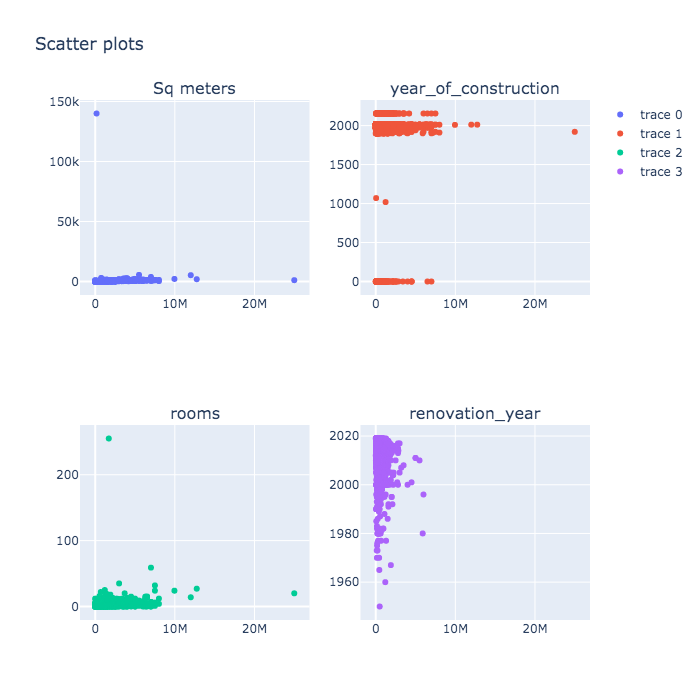

In [18]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Initialize figure with subplots
fig = make_subplots(
    rows=2, cols=2, subplot_titles=("Sq meters", "year_of_construction", "rooms", "renovation_year")
)

# Add traces
fig.add_trace(go.Scatter(x=data['price'], y=data['sq_meters'],mode='markers'), row=1, col=1)
fig.add_trace(go.Scatter(x=data['price'], y=data['year_of_construction'],mode='markers') ,row=1, col=2)
fig.add_trace(go.Scatter(x=data['price'], y=data['rooms'],mode='markers'), row=2, col=1)
fig.add_trace(go.Scatter(x=data['price'], y=data['renovation_year'],mode='markers'),  row=2, col=2)



# Update title and height
fig.update_layout(title_text="Scatter plots", height=700)
if plotly=='yes':
    fig.show()
else:
    fig.show("png")

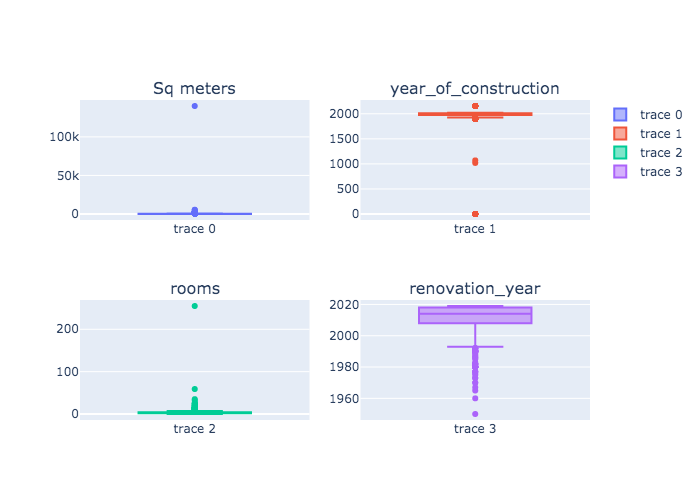

In [19]:
fig = make_subplots(
    rows=2, cols=2, subplot_titles=("Sq meters", "year_of_construction","rooms", "renovation_year")
)
fig.add_trace(go.Box( y=data["sq_meters"]), row=1, col=1)
fig.add_trace(go.Box(y=data["year_of_construction"]),row=1, col=2)
fig.add_trace(go.Box( y=data["rooms"]), row=2, col=1)
fig.add_trace(go.Box(y=data["renovation_year"]),row=2, col=2)
if plotly=='yes':
    fig.show()
else:
    fig.show("png")

### Removing outliers - Data Cleansing
There would be many different apporaches to removing outliers. Some of them include fitting models which compute deviations of data points in comparison to their neighboring points. In our case we can visually check for outliers, or use the boxplots above and our intuition.

For example, we wouldn't expect a house to be 140k square meters and have 3 rooms. We also wouldn't expect a house to have 0 rooms or be sold at 0 price or even be constructed at year 0, or 1000. Though having a second look at the listing with year_of_construction 0 seem to have reasonable rest of the properties, so we can also assume that the year was just not available.

In [20]:
def clean_dataset(data):
    data = data[(data['sq_meters'] != 1) & (data['sq_meters'] != 14000)]
    data = data[(data['year_of_construction'] != 1070) ]
    data = data[(data['rooms'] != 255) ]
    data = data[(data['price'] > 1000) ]
    # Drop where agent_id is null
    data = data.dropna(subset=['agent_id'])
    return data
                              
data=clean_dataset(data)
print("Total number of rows is", len(data.index))

Total number of rows is 15300


The same listing might be uploaded by different agents. In order to find duplicates we can assume that certain properties will be the same amongst them like the square meters, the number of rooms, the number of living rooms, the year of construction, etc. Obviously the price might and the ranking might be different amongst different agents. Below we remove the duplicate listings. 

In [21]:
# Duplicate listings
props=['sq_meters','subtype','geography_name','floor','rooms','living_rooms', 'kitchens','no_of_wc',
                             'year_of_construction','no_of_bathrooms']
data=data.drop_duplicates(subset=props, keep='first')
print("Total number of rows is", len(data.index))

Total number of rows is 13558


By removing duplicates the total number of rows reduced from 15300 to 13558

### 1. Property prices per house type (subtype) and per area (geography_name)  <a class="anchor" id="metrics"></a>

In [22]:
df_prices=data[['price','subtype','geography_name']]
df_prices=df_prices.groupby(['geography_name','subtype']).agg({"price": [np.mean, np.median,np.std ]})
df_prices=df_prices.sort_values([('price', 'mean')], ascending=False)
round(df_prices,2)

price                     
                                             mean   median         std
geography_name      subtype                                           
northern sub        apartment complex  3376923.08  2000000  2901121.58
                    villa              2285754.39  1800000  1816225.96
south beach         other residential  2204142.86  1100000  2948510.21
                    villa              1951041.67  1750000  1198105.37
                    building           1849251.85  1200000  1667502.84
northern sub        other residential  1592985.19   900000  1788831.72
south beach         apartment complex  1471703.70  1200000  1086463.52
northern sub        building           1445164.00  1050000  1596047.62
gentrification area building           1303030.30   750000  1518651.20
northern sub        detached           1280082.70   900000  1314861.49
south beach         detached           1107285.53   950000   744019.75
                    maisonette          877835.86   690000   582941.18
gentrification area detached            801486.49   625000   495542.44
northern sub        maisonette          729372.73   600000   427030.70
south beach         loft                553272.73   369000   357646.78
beesy neighborhood  building            509849.06   435000   371487.79
gentrification area apartment complex   509500.00   509500   340118.36
northern sub        apartment           489663.45   386500   381237.36
beesy neighborhood  other residential   486611.11   355000   824784.62
south beach         apartment           446938.40   345000   334762.39
beesy neighborhood  apartment complex   394285.71   450000   192795.85
gentrification area other residential   321250.00   302500   169616.16
beesy neighborhood  detached            319695.65   250000   250637.46
gentrification area maisonette          249437.50   187500   129935.87
beesy neighborhood  maisonette          215605.26   195000   112885.39
gentrification area apartment           201976.82   190000    98501.98
beesy neighborhood  apartment           108178.94    90000    69165.85
south beach         studio              101095.24    85000    51780.87
                    bungalow             66500.00    66500     2121.32
gentrification area studio               61838.71    65000    21574.83
northern sub        studio               60000.00    60000        0.00
beesy neighborhood  studio               35429.41    26000    24515.32

From the table above we can see that the apartment complexes and villas in the northern suburbds have the highest average prices followed by other residential and villa listings in the south beach. As expected their standard deviation is also the highest, meaning that values tend to be dispersed more from the mean.

On the other hand, small apartments (e.g. studios) in beesy neighborhood have the lowest prices.


#### Prices  per geography name

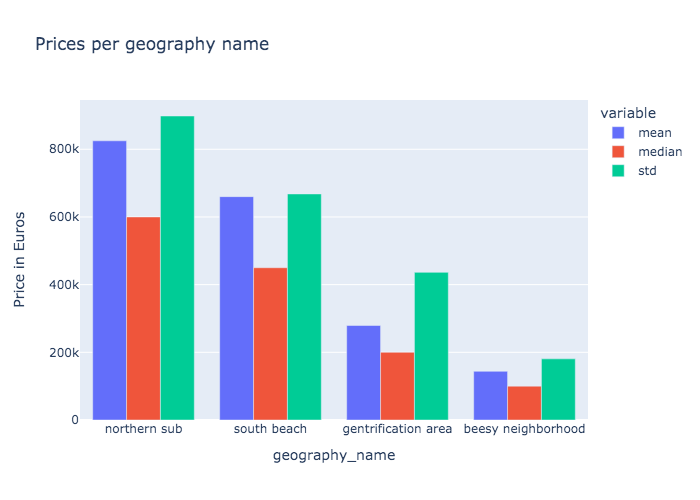

In [23]:
geography_name=data[['price','geography_name']]
geography_name=geography_name.groupby(['geography_name']).agg({"price": [np.mean, np.median,np.std ]})
geography_name=geography_name.sort_values([('price', 'mean')], ascending=False)
geography_name=geography_name.droplevel(0, axis=1)
fig = px.bar(geography_name, x=geography_name.index, y=["mean", "median", "std"], title="Prices per geography name")
fig.update_layout(barmode='group')
fig.update_yaxes(title="Price in Euros")
if plotly=='yes':
    fig.show()
else:
    fig.show("png")

### Prices per subtype

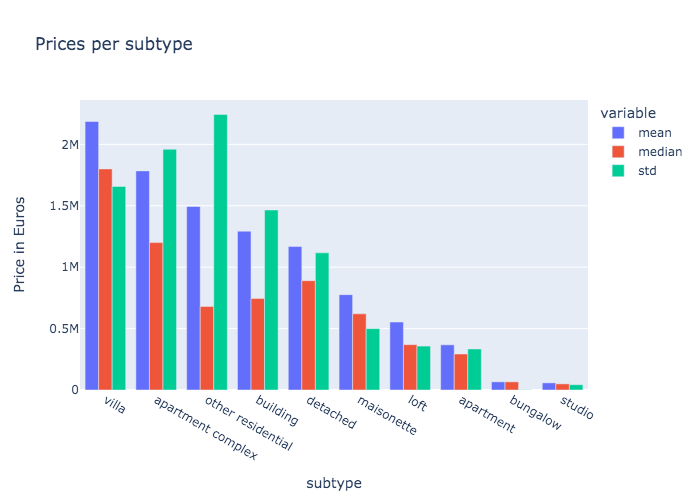

In [24]:
subtype=data[['price','subtype']]
subtype
subtype=subtype.groupby(['subtype']).agg({"price": [np.mean, np.median,np.std ]})
subtype=subtype.sort_values([('price', 'mean')], ascending=False)
subtype=subtype.droplevel(0, axis=1)
fig = px.bar(subtype, x=subtype.index, y=["mean", "median", "std"], title="Prices per subtype")
fig.update_yaxes(title="Price in Euros")
fig.update_layout(barmode='group')
if plotly=='yes':
    fig.show()
else:
    fig.show("png")

### 2. Competitiveness metrics of an area  <a class="anchor" id="competitiveness-metrics"></a>

A highly competitive area would mean that it would be hard for a simple listing to rank high in the search results of this area just by having a high ranking score. I have created two metrics to show how much saturated each area is from  high ranking score listings. One of them includes splitting the listings into bins based on the ranking and checking the distribution of listings per area within each bin and the other will be ordering the results by ranking score and checking the listing distribution per 500 of results. The greater the count of high ranking score listings on the top position the more competitive a market is assumed to be.

In [25]:
# Sort our data for ranking score and keep only the simple listings
df_sorted=data.sort_values(by='ranking_score', ascending=False)
df_sorted=df_sorted.loc[df_sorted['ad_type']=='simple']
df_sorted.head(5)

,id,ranking_score,agent_id,geography_name,sq_meters,price,year_of_construction,floor,subtype,rooms,...,neoclassic,double_glass,for_commercial_use,fireplace,elevator,satellite,solar_heater,attic,pool,playroom
39,43014638,179.0,9781.0,northern sub,400,550000,1987,ground-floor,detached,5,...,False,True,False,True,False,False,True,False,False,True
3014,42831164,178.5,15340.0,northern sub,460,1000000,2002,1,detached,6,...,False,True,False,True,True,True,False,False,False,True
5127,38152604,177.5,10920.0,northern sub,378,2900000,2014,2,maisonette,3,...,False,True,False,False,True,True,False,True,True,True
14902,42878418,177.0,12106.0,south beach,108,500000,1988,4,apartment,3,...,False,True,False,True,True,False,True,False,True,False
5130,38153562,175.5,10920.0,northern sub,507,3100000,2014,ground-floor,maisonette,4,...,False,True,False,True,True,True,False,False,True,True


In [26]:
# We can group the listing in bins of 10 for ranking score above 100 (the 100 threshold is a a bit abstract)
bins = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
groups = df_sorted[['ranking_score','geography_name']].groupby(['geography_name', pd.cut(df_sorted.ranking_score, bins)])
ranks_geography=groups.size().unstack()
ranks_geography.columns = ranks_geography.columns.astype(str).str.replace("(", "[")
ranks_geography

ranking_score,"[100, 110]","[110, 120]","[120, 130]","[130, 140]","[140, 150]","[150, 160]","[160, 170]","[170, 180]","[180, 190]"
geography_name,,,,,,,,,
beesy neighborhood,170,195,222,155,201,200,58,1,0
gentrification area,53,86,88,82,91,62,28,1,0
northern sub,360,486,579,615,463,379,235,36,0
south beach,538,615,744,671,658,583,314,30,0


From the table above, we can see that for scores between 170 and 180 we have 36 listings in northern suburbs and 38 in south beach. For ranking scores between 160-170, south beach has the majority of listings. We can assume that the competition there is much tighter.

In [27]:
# We can also get the above results in terms of percentages
ranks_geography.div(ranks_geography.sum(axis=1), axis=0)
ranks_geography=(ranks_geography / ranks_geography.sum())*100
ranks_geography.columns = ranks_geography.columns.astype(str).str.replace("(", "[")
ranks_geography

ranking_score,"[100, 110]","[110, 120]","[120, 130]","[130, 140]","[140, 150]","[150, 160]","[160, 170]","[170, 180]","[180, 190]"
geography_name,,,,,,,,,
beesy neighborhood,15.165031,14.109986,13.594611,10.177282,14.225053,16.339869,9.133858,1.470588,NaN
gentrification area,4.727921,6.222865,5.388855,5.384110,6.440198,5.065359,4.409449,1.470588,NaN
northern sub,32.114184,35.166425,35.456216,40.380827,32.767162,30.964052,37.007874,52.941176,NaN
south beach,47.992864,44.500724,45.560318,44.057781,46.567587,47.630719,49.448819,44.117647,NaN


So for ranking scores between 170 and 180, 53% of the listing are in northern suburbs and 44% in south beach. While 49.5% of the listings with scores between 160 and 170 belongs to south beach.

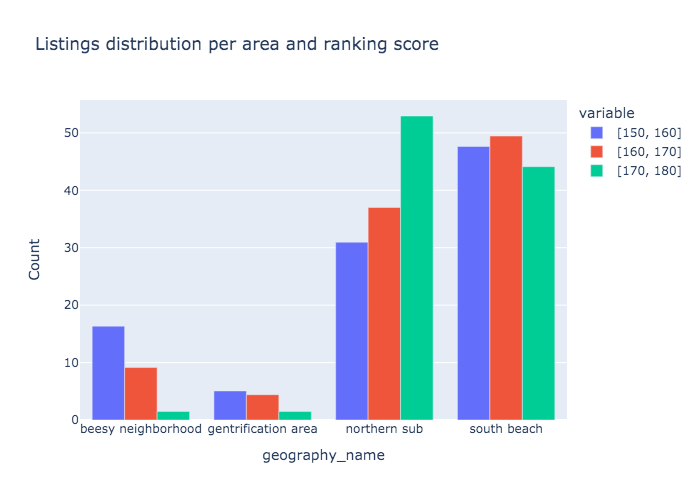

In [28]:
fig = px.bar(ranks_geography, x=ranks_geography.index, y= ["[150, 160]","[160, 170]","[170, 180]"],title="Listings distribution per area and ranking score")
fig.update_layout(barmode='group')
fig.update_yaxes(title="Count")
if plotly=='yes':
    fig.show()
else:
    fig.show("png")

### Listings distribution per area for every 500 of results order by ranking score 

In [29]:
# We can sort our data group them  for every 500 results
df_sorted=data.sort_values(by='ranking_score', ascending=False)
df_sorted_sub = df_sorted.reset_index(drop=True)
df_sorted_sub['order_id']= (df_sorted_sub.index / 500 + 1).astype(int)
df_sorted_sub=df_sorted_sub[['order_id','geography_name','ranking_score']]
df_sorted_sub

,order_id,geography_name,ranking_score
0,1,gentrification area,182.8
1,1,northern sub,181.9
2,1,northern sub,179.0
3,1,northern sub,178.5
4,1,gentrification area,177.7
...,...,...,...
13553,28,beesy neighborhood,22.2
13554,28,beesy neighborhood,20.5
13555,28,beesy neighborhood,20.0
13556,28,northern sub,18.0


In [30]:
# Now we cal calulate how many listings per area and per every 500 ordered results
# Order_id 1 are the results 0-500, order_id 2 the ones between 501-100 and so on
df_groups=df_sorted_sub.groupby(['geography_name','order_id']).agg(['count'])
df_groups=df_groups.droplevel(0, axis=1)
df_groups=df_groups.reset_index()
df_groups=df_groups.sort_values(by=['order_id','count'], ascending=(True, False))
df_groups

,geography_name,order_id,count
56,northern sub,1,224
84,south beach,1,223
0,beesy neighborhood,1,27
28,gentrification area,1,26
85,south beach,2,231
...,...,...,...
54,gentrification area,27,24
111,south beach,28,35
27,beesy neighborhood,28,11
83,northern sub,28,7


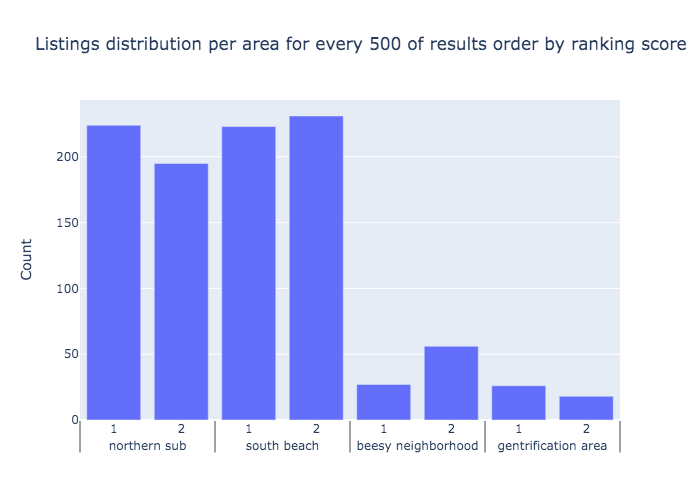

In [31]:
import plotly.graph_objects as go
df_groups=df_groups[(df_groups['order_id']==1) | (df_groups['order_id'] == 2)]
l = []
l.append(df_groups['geography_name'].tolist())
l.append(df_groups['order_id'].tolist())
fig = go.Figure()
fig.add_bar(x=l,y=[i[0] for i in df_groups[['count']].to_numpy().tolist()])
fig.update_layout(title='Listings distribution per area for every 500 of results order by ranking score')
fig.update_yaxes(title="Count")
if plotly=='yes':
    fig.show()
else:
    fig.show("png")

In the graph above we can see that south beach and norther suburbs have the most listings for the first 1000 of results ordered by ranking score. Class 1 is the first 500 highest ranked results and 2 the second 500 ones.